Copyright (C) Microsoft Corporation.

# PreProcessing of Images for TF OD API  

In this notebook, we create tensorflow records for training and validation datasets, details can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)

In [1]:
# !azcopy --source https://olympusvideoblob.blob.core.windows.net/grocerydemolabeled/Converted\ \JPG\ with\ xml\ runfourftvalidation/ --destination ./annotated_val --source-key rn0do+y1iUoMuAx1l7EYTZDxktgV961RHKaSz34uOIom8fUEQMXM0kDEUf4RlKY0qc/lsn0oNtTDFT/Rvu4deA== --recursive

In [2]:
import sys
import os
import io
import glob
from PIL import Image
import random
from lxml import etree
import contextlib2

from IPython.display import display
from utilities import create_dir
random.seed(4)

import tensorflow as tf
sys.path.append("../models/research/") # Modify to point to your tensorflow models directory
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.dataset_tools import tf_record_creation_util

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
# Annotated Images directory
data_dir = './annotated_val/'

# Label map path
label_map_path = './stockout_label_map.pbtxt'

# Outputs path
output_dir = 'outputdata_test'

In [3]:
create_dir(output_dir)

exists


In [3]:
# Read label dictionary
label_map_dict = label_map_util.get_label_map_dict(label_map_path)
class_name = 'stockout'

In [4]:
# Tensorflow record output paths
test_output_path = os.path.join(output_dir, 'stockout_test.record')

In [5]:
in_images = glob.glob(data_dir + '*.jpg')
print("There are {} images.".format(len(in_images)))

There are 182 images.


In [11]:
# in_images_sub = glob.glob(data_dir + '/**/**/'+ '*.jpg')
# print("There are {} images.".format(len(in_images_sub)))

In [12]:
# in_images = in_images + in_images_sub
# print("There are {} images.".format(len(in_images)))

In [13]:
# # train, validation  split
# num_val = int(len(in_images) * 0.1)
# num_train = len(in_images) - num_val 
# print(num_train, num_val)

In [13]:
# val_images = random.sample(in_images, num_val)
# train_images = [img for img in in_images if img not in val_images]

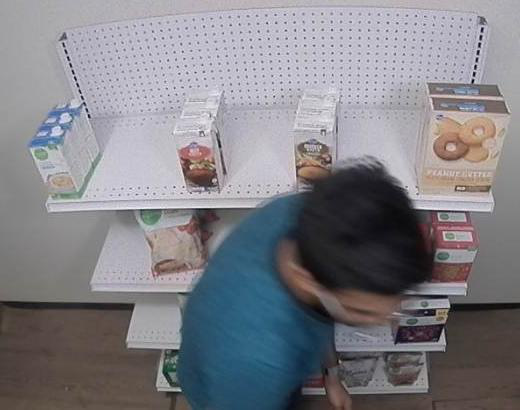

(520, 410)


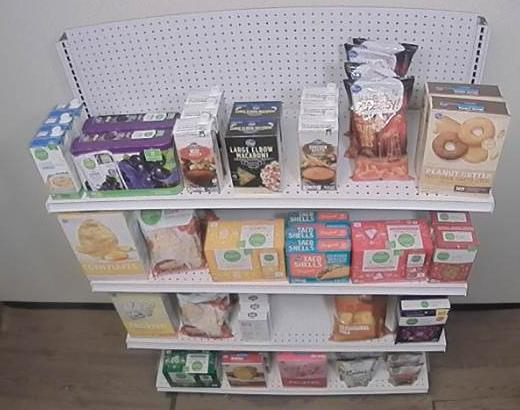

(520, 410)


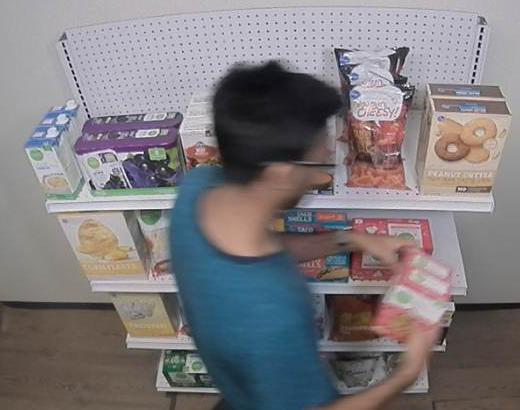

(520, 410)


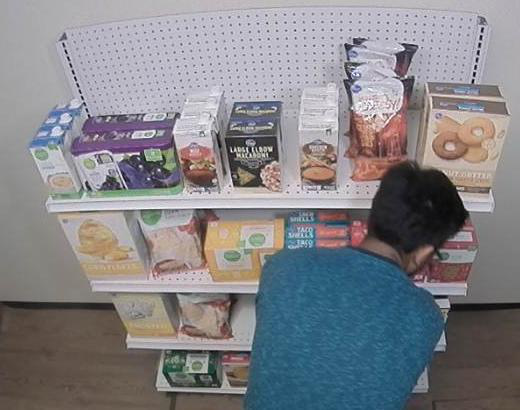

(520, 410)


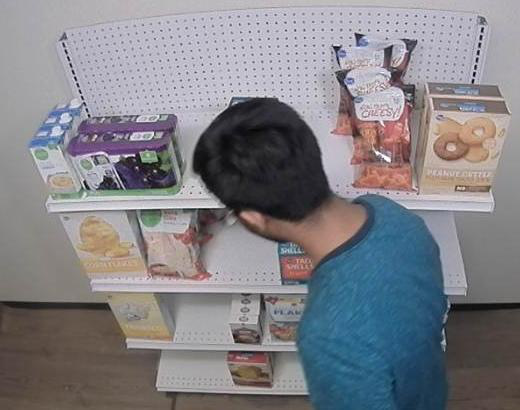

(520, 410)


In [6]:
# Sample of  images
for img_path in in_images[:5]:
    img = Image.open(img_path)
    display(img)
    print(img.size)

In [11]:
def dict_to_tf_example(data, label_map_dict, img_path):
    
#     img_path = os.path.join(img_dir, data['filename'])
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    classes = []
    classes_text = []

    if 'object' in data:
        for obj in data['object']:
            xmin = float(obj['bndbox']['xmin'])
            xmax = float(obj['bndbox']['xmax'])
            ymin = float(obj['bndbox']['ymin'])
            ymax = float(obj['bndbox']['ymax'])

            xmins.append(xmin / width)
            ymins.append(ymin / height)
            xmaxs.append(xmax / width)
            ymaxs.append(ymax / height)
            classes_text.append(class_name.encode('utf8'))
            classes.append(label_map_dict[class_name])   
    feature_dict = {
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example

In [12]:
def create_tf_record(output_filename, num_shards, label_map_dict, examples):
    
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(tf_record_close_stack, output_filename, num_shards)

        for idx, example in enumerate(examples):
            if idx % 1 == 0:
                print('On image {} of {}'.format(idx, len(examples)))
            xml_path = os.path.join(example[:-4] + '.xml')
            if not os.path.exists(xml_path):
                print('Could not find {}, ignoring example'.format(xml_path))
                continue
            with tf.gfile.GFile(xml_path, 'r') as fid:
                xml_str = fid.read()
            xml = etree.fromstring(xml_str)
            data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

            try:
                tf_example = dict_to_tf_example(data, label_map_dict, example)
                if tf_example:
                    shard_idx = idx % num_shards
                    output_tfrecords[shard_idx].write(tf_example.SerializeToString())
            except ValueError:
                print('Invalid example: {}, ignoring.'.format(xml_path))

In [13]:
# Create tensorflow records for training
create_tf_record(test_output_path, 1, label_map_dict, in_images)

On image 0 of 182
On image 1 of 182
On image 2 of 182
On image 3 of 182
On image 4 of 182
On image 5 of 182
On image 6 of 182
On image 7 of 182
On image 8 of 182
On image 9 of 182
On image 10 of 182
On image 11 of 182
On image 12 of 182
On image 13 of 182
On image 14 of 182
On image 15 of 182
On image 16 of 182
On image 17 of 182
On image 18 of 182
On image 19 of 182
On image 20 of 182
On image 21 of 182
On image 22 of 182
On image 23 of 182
On image 24 of 182
On image 25 of 182
On image 26 of 182
On image 27 of 182
On image 28 of 182
On image 29 of 182
On image 30 of 182
On image 31 of 182
On image 32 of 182
On image 33 of 182
On image 34 of 182
On image 35 of 182
On image 36 of 182
On image 37 of 182
On image 38 of 182
On image 39 of 182
On image 40 of 182
On image 41 of 182
On image 42 of 182
On image 43 of 182
On image 44 of 182
On image 45 of 182
On image 46 of 182
On image 47 of 182
On image 48 of 182
On image 49 of 182
On image 50 of 182
On image 51 of 182
On image 52 of 182
On 

# Evaluate 

In [14]:
!cp ./model_maskrcnn/stockout_pipeline.config ./model_maskrcnn/stockout_pipeline_test.config

Change the number of examples , path to test records.

In [26]:
!cat ./model_maskrcnn/stockout_pipeline_test.config

model {
  faster_rcnn {
    number_of_stages: 2
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 800
        max_dimension: 1365
      }
    }
    feature_extractor {
      type: "faster_rcnn_inception_v2"
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        height_stride: 16
        width_stride: 16
        scales: 0.25
        scales: 0.5
        scales: 1.0
        scales: 2.0
        aspect_ratios: 0.25
        aspect_ratios: 0.5
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 3.0
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.00999999977648
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.6
    first

From ./models/research/ directory, run the following

```
python object_detection/model_main.py --pipeline_config_path=/datadrive/OutOfStockDemo/model_maskrcnn/stockout_pipeline_test.config --model_dir=/datadrive/OutOfStockDemo/model_maskrcnn/ --checkpoint_dir=/datadrive/OutOfStockDemo/model_maskrcnn --run_once=True --alsologtostderr
```

# Write detections 

In [7]:
import numpy as np
import os
import sys
import tensorflow as tf
import glob

from distutils.version import StrictVersion
from collections import defaultdict
from PIL import Image
from utilities import create_dir, load_image_into_numpy_array
from IPython.display import display

sys.path.append("../models/research/") # Modify to point to your tensorflow models directory
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
print(tf.__version__)

1.12.0


In [8]:
OUT_IMAGES = './test_maskrcnn'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = './export_maskrcnn/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './stockout_label_map.pbtxt'

In [9]:
create_dir(OUT_IMAGES)

exists


In [10]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [13]:
# Size, in inches, of the output images.
IMAGE_SIZE = (24, 18)

In [14]:
%%time

for image_path in in_images:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
#         min_score_thresh=.85,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=4)
    image_np = Image.fromarray(image_np)
    save_path = os.path.split(image_path)[-1]
    image_np.save(os.path.join(OUT_IMAGES, save_path))
    print(save_path)

1556246134.1030817.jpg
1556246275.3635554.jpg
1556246393.8947294.jpg
1556246224.4983842.jpg
1556245876.9242468.jpg
1556246302.4657276.jpg
1556245733.424522.jpg
1556245826.5263066.jpg
1556246518.1535065.jpg
1556245750.2968655.jpg
1556245905.0010264.jpg
1556245757.0192983.jpg
1556245604.4818022.jpg
1556245817.606081.jpg
1556245645.9958413.jpg
1556246085.609887.jpg
1556245647.1107254.jpg
1556245922.983771.jpg
1556245946.6160455.jpg
1556246204.080803.jpg
1556246084.4970593.jpg
1556246223.34453.jpg
1556246031.480617.jpg
1556245770.5033612.jpg
1556246573.4157803.jpg
1556245648.2217717.jpg
1556245945.468072.jpg
1556246110.3978791.jpg
1556246218.829202.jpg
1556245818.7370672.jpg
1556246467.3498888.jpg
1556245842.1835918.jpg
1556246211.9748597.jpg
1556246234.6346788.jpg
1556246287.8349838.jpg
1556246225.6185818.jpg
1556245610.0719967.jpg
1556245732.3077428.jpg
1556246516.9819274.jpg
1556245878.095117.jpg
1556245593.1889908.jpg
1556246169.079372.jpg
1556246512.4567378.jpg
1556245709.904177.jpg
1

In [9]:
test_images_detect = glob.glob(OUT_IMAGES + '/*.jpg')

In [11]:
# for img_path in test_images_detect:
#     img = Image.open(img_path)
#     display(img)
#     print(img.size)